EOD strategies could be rebalanced max once per week to consider brokerage and other costs 

We can use the momentum logic to create a ranking logic for a possible long-short equity algo. This could be done on futures so that we would be market neutral to some extent. 
The idea is to pick top ranks from 
1) stocks that are having positive momentum - bullish 
2) stocks that have negative momentum - bearish 

So at any point if market decides to go up or down as systematic risk our exposures will be managed

Additionally we can explore the ADX indicator to see if it is acting as a confirmation to our momentum stock picks 
We could also reduce the frequency of 6month testing to a quarter or maybe 1 month too so that we don’t enter in the stock too late

Strategy:
1.	Lookback period – 126 plus 1st Tuesday after that
2.	Need to run very Tuesday of the week
3.	Initial Capital – 200000
4.	Weighting – Inverse of volatility 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
idx = pd.IndexSlice

In [3]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import investpy
import pyfolio as pf
import backtrader as bt
import collections
from scipy.stats import linregress

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
np.random.seed(42)
bt.__version__

'1.9.76.123'

In [5]:
DATA_STORE = '../../Data-Daily/india_asset.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    nifty200_m = (store['/nse/nifty200/metadata'])
tickers = nifty200_m.dropna().symbol.to_list()
print(len(tickers))

197


In [7]:
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close    high    low   open   volume
ticker date                                             
ACC    2000-01-03  268.55  271.45  255.1  258.9  5447617
       2000-01-04  256.60  269.50  255.1  268.0  2978528
       2000-01-05  250.30  268.00  244.5  249.9  2802364

In [8]:
# remove tickers where we have less than 10 years of data.
min_obs =  2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 621400 entries, ('ABOT', Timestamp('2000-01-03 00:00:00')) to ('ZEE', Timestamp('2021-01-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   621400 non-null  float64
 1   high    621400 non-null  float64
 2   low     621400 non-null  float64
 3   open    621400 non-null  float64
 4   volume  621400 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 26.3+ MB


In [9]:
prices.index.unique(level='ticker')

Index(['ABOT', 'ABUJ', 'ACC', 'ADEL', 'AMAR', 'APLH', 'APLO', 'APSE', 'ARBN',
       'ARTI',
       ...
       'ULTC', 'UNBK', 'UNSP', 'UPLL', 'VGUA', 'VODA', 'VOLT', 'WHIR', 'WIPR',
       'ZEE'],
      dtype='object', name='ticker', length=154)

In [10]:
prices.loc['ACC'].index[-132]

Timestamp('2020-07-23 00:00:00')

In [11]:
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2021, 1, 21)

In [12]:
# Calculate momentum
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

In [13]:
class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=126)
    func = momentum_func

In [14]:
vola_window = 21
# we take a 126-day time series of closing prices, 
# calculate the daily returns, and take a mean of 21 days rolling window of standards deviation.
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().iloc[-1]
    return std

In [15]:
class StrategyRiskparity(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=90,
        num_positions=20,
        rebalance_days = [1],

        printlog=False,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.datas:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)
            self.inds[d]['adx'] = bt.indicators.ADX(d, period=14)
#             self.inds[d]['rsi'] = bt.indicators.RSI(d, period=14)
#             self.inds[d]['MACD'] = bt.indicators.MACD(d)
#             # Cross of macd.macd and macd.signal
#             self.inds[d]['mcross'] = bt.indicators.CrossOver(self.inds[d]['MACD'].macd, self.inds[d]['MACD'].signal)
            

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # Sell stocks no longer meeting ranking filter and create list of kept positions
        kept_positions = []
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i))
                elif i < self.p.num_positions:
                    kept_positions.append(d._name)
        self.log('kept_positions - %s'% kept_positions)
        
        # Based on kept position and new ranking identify new long positions to add
        new_positions = []
        for i, d in enumerate(rankings[:self.p.num_positions]):
            if d._name not in (kept_positions):
                new_positions.append(d._name)
        self.log('new_positions - %s'% new_positions)
        
        # Calculate volatility table
        hist = pd.DataFrame()
        for d in self.securities:
            if d._name in (new_positions):
                hist[d._name] = d.close.get(size=self.p.momentum_period)
        vola_table = hist.apply(volatility)
        self.log('vola_table - %s'% vola_table)
        
        # Calculate weights based on volatility 
        inv_vola_table = 1 / vola_table 
        sum_inv_vola = np.sum(inv_vola_table)         
        vola_target_weights = inv_vola_table / sum_inv_vola
        self.log('vola_target_weights - %s'% vola_target_weights)
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                if (self.inds[d]['adx'][0] > 25): #(self.inds[d]['rsi'][0] < 25): #and (self.inds[d]['rsi'][-1] > 25) and (self.inds[d]['adx'][0] < 25):
                    weight = vola_target_weights[d._name]
                    self.order_target_percent(d, target=weight)
                    self.log('Buy {} - Rank {:.2f} - Close {:.2f}'.format(d._name, i, d.close[0])) 
                
    def next_open(self):
        dt = self.data.datetime.datetime()
        if dt.weekday() in self.p.rebalance_days:
            self.rebalance()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, order.executed.value, order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()), doprint=False)

In [16]:
# Model Settings
startcash = 200000
momentum_period = 126 #days
num_positions = 20 
rebalance_days = [1]
reserve = 0.05
printlog=True


# Commission and Slippage Settings
commission = 0.0025

In [17]:
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)
# cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [18]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: ADEL
Adding ticker: AMAR
Adding ticker: APLH
Adding ticker: APLO
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ARTI
Adding ticker: ASOK
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BAJE
Adding ticker: BATA
Adding ticker: BBRM
Adding ticker: BFRG
Adding ticker: BHEL
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BLKI
Adding ticker: BOB
Adding ticker: BOI
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CAST
Adding ticker: CCRI
Adding ticker: CESC
Adding ticker: CHLA
Adding ticker: CNBK
Adding ticker: COAL
Adding ticker: COLG
Adding ticker: CORF
Adding ticker: CTBK
Adding ticker: CUMM
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: EDEL
Adding ticker: EMAM
Adding ticker: ESCO
Adding ticker: EXID
Adding ticker: FED
Addin

In [19]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyRiskparity,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    rebalance_days = rebalance_days,
                    printlog = printlog,
                    reserve = reserve
                   )

0

In [20]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_eq_wts = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 200000.00
2011-05-17T00:00:00, kept_positions - []
2011-05-17T00:00:00, new_positions - ['PIIL', 'PFIZ', 'MOSS', 'HCLT', 'PAGE', 'COAL', 'HZNC', 'SIEM', 'BATA', 'CADI', 'PGRD', 'BJFS', 'CESC', 'BHEL', 'UBBW', 'GMRI', 'SUTV', 'IHTL', 'GLEN', 'LART']
2011-05-17T00:00:00, vola_table - BATA    0.022343
BHEL    0.016311
BJFS    0.018030
CADI    0.017260
CESC    0.017041
COAL    0.020177
GLEN    0.033821
GMRI    0.018681
HCLT    0.026201
HZNC    0.020357
IHTL    0.016366
LART    0.015940
MOSS    0.018801
PAGE    0.012907
PFIZ    0.018353
PGRD    0.011766
PIIL    0.017773
SIEM    0.016431
SUTV    0.017477
UBBW    0.038109
dtype: float64
2011-05-17T00:00:00, vola_target_weights - BATA    0.040961
BHEL    0.056108
BJFS    0.050759
CADI    0.053026
CESC    0.053707
COAL    0.045358
GLEN    0.027060
GMRI    0.048990
HCLT    0.034930
HZNC    0.044957
IHTL    0.055921
LART    0.057415
MOSS    0.048679
PAGE    0.070906
PFIZ    0.049865
PGRD    0.077786
PIIL    0.051493
SIEM

2011-08-02T00:00:00, Leave MAXI - Rank 24.00
2011-08-02T00:00:00, Leave EXID - Rank 33.00
2011-08-02T00:00:00, kept_positions - ['BATA', 'JUBI', 'VGUA', 'AMAR', 'TREN', 'PIIL', 'TITN', 'DIVI', 'BLKI']
2011-08-02T00:00:00, new_positions - ['CAST', 'BRIT', 'EMAM', 'IGAS', 'ASPN', 'BRGR', 'PAGE', 'PIDI', 'APLO', 'GOCP', 'ITC']
2011-08-02T00:00:00, vola_table - APLO    0.019699
ASPN    0.009490
BRGR    0.017909
BRIT    0.010556
CAST    0.022107
EMAM    0.014256
GOCP    0.013181
IGAS    0.015331
ITC     0.014047
PAGE    0.022144
PIDI    0.017431
dtype: float64
2011-08-02T00:00:00, vola_target_weights - APLO    0.068889
ASPN    0.142997
BRGR    0.075772
BRIT    0.128554
CAST    0.061385
EMAM    0.095192
GOCP    0.102951
IGAS    0.088517
ITC     0.096605
PAGE    0.061284
PIDI    0.077853
dtype: float64
2011-08-02T00:00:00, Buy EMAM - Rank 10.00 - Close 163.75
2011-08-02T00:00:00, Buy IGAS - Rank 11.00 - Close 84.55
2011-08-02T00:00:00, Buy PAGE - Rank 15.00 - Close 2228.45
2011-08-02T00:00:00

2011-09-20T00:00:00, Leave VGUA - Rank 27.00
2011-09-20T00:00:00, kept_positions - ['BATA', 'PIIL', 'PAGE', 'VODA', 'JUBI', 'BLKI', 'AMAR', 'TREN', 'HROM', 'EMAM']
2011-09-20T00:00:00, new_positions - ['IGAS', 'PLNG', 'NAFL', 'BRIT', 'ASPN', 'MAXI', 'HLL', 'NEST', 'GGAS', 'COLG']
2011-09-20T00:00:00, vola_table - ASPN    0.012779
BRIT    0.014233
COLG    0.020110
GGAS    0.019469
HLL     0.015485
IGAS    0.014650
MAXI    0.028096
NAFL    0.021190
NEST    0.012005
PLNG    0.022689
dtype: float64
2011-09-20T00:00:00, vola_target_weights - ASPN    0.132053
BRIT    0.118559
COLG    0.083912
GGAS    0.086677
HLL     0.108974
IGAS    0.115186
MAXI    0.060062
NAFL    0.079637
NEST    0.140564
PLNG    0.074376
dtype: float64
2011-09-20T00:00:00, Buy NAFL - Rank 7.00 - Close 74.32
2011-09-20T00:00:00, Buy BRIT - Rank 8.00 - Close 229.22
2011-09-20T00:00:00, Buy HLL - Rank 15.00 - Close 343.00
2011-09-20T00:00:00, Order Canceled/Margin/Rejected
2011-09-20T00:00:00, SELL EXECUTED, Price: 15.48, 

2011-12-13T00:00:00, Leave BATA - Rank 42.00
2011-12-13T00:00:00, Leave IGAS - Rank 109.00
2011-12-13T00:00:00, kept_positions - ['REXP', 'PAGE', 'PIIL', 'SANO', 'NAFL', 'HROM', 'HLL', 'BLKI', 'VODA']
2011-12-13T00:00:00, new_positions - ['TRCE', 'ACC', 'BAJA', 'ABUJ', 'ULTC', 'TVSM', 'SHCM', 'GRAS', 'APLH', 'DABU', 'MAHM']
2011-12-13T00:00:00, vola_table - ABUJ    0.025173
ACC     0.023950
APLH    0.037943
BAJA    0.018566
DABU    0.015568
GRAS    0.020356
MAHM    0.025155
SHCM    0.013252
TRCE    0.020859
TVSM    0.022508
ULTC    0.020024
dtype: float64
2011-12-13T00:00:00, vola_target_weights - ABUJ    0.074590
ACC     0.078400
APLH    0.049486
BAJA    0.101136
DABU    0.120611
GRAS    0.092240
MAHM    0.074642
SHCM    0.141685
TRCE    0.090017
TVSM    0.083421
ULTC    0.093772
dtype: float64
2011-12-13T00:00:00, Buy TRCE - Rank 1.00 - Close 110.75
2011-12-13T00:00:00, Buy ULTC - Rank 6.00 - Close 1142.60
2011-12-13T00:00:00, Buy TVSM - Rank 10.00 - Close 53.90
2011-12-13T00:00:00, 

2012-02-14T00:00:00, Leave BJAT - Rank 35.00
2012-02-14T00:00:00, kept_positions - ['TAMO', 'SHCM', 'HVEL', 'HLL', 'TRCE', 'GRAS', 'TCS', 'REDY', 'ULTC', 'APLH', 'REXP']
2012-02-14T00:00:00, new_positions - ['WIPR', 'MINT', 'ABUJ', 'LICH', 'PIRA', 'SUN', 'ACC', 'INFY', 'APLO']
2012-02-14T00:00:00, vola_table - ABUJ    0.019697
ACC     0.018957
APLO    0.023504
INFY    0.011462
LICH    0.024358
MINT    0.015180
PIRA    0.013796
SUN     0.014368
WIPR    0.016010
dtype: float64
2012-02-14T00:00:00, vola_target_weights - ABUJ    0.093190
ACC     0.096829
APLO    0.078094
INFY    0.160148
LICH    0.075359
MINT    0.120922
PIRA    0.133053
SUN     0.127755
WIPR    0.114651
dtype: float64
2012-02-14T00:00:00, Buy WIPR - Rank 2.00 - Close 191.18
2012-02-14T00:00:00, Buy MINT - Rank 4.00 - Close 445.05
2012-02-14T00:00:00, Buy ABUJ - Rank 9.00 - Close 170.75
2012-02-14T00:00:00, Buy LICH - Rank 11.00 - Close 269.50
2012-02-14T00:00:00, Buy PIRA - Rank 13.00 - Close 435.80
2012-02-14T00:00:00, B

2012-04-03T00:00:00, Leave GRAS - Rank 22.00
2012-04-03T00:00:00, kept_positions - ['TAMO', 'SHCM', 'HVEL', 'MRF', 'APLO', 'TRCE', 'PIRA', 'MINT', 'ULTC', 'WIPR']
2012-04-03T00:00:00, new_positions - ['IPCA', 'NATP', 'TAGL', 'ARTI', 'BLKI', 'AMAR', 'SUN', 'JUBI', 'UBBW', 'SUTV']
2012-04-03T00:00:00, vola_table - AMAR    0.013982
ARTI    0.016613
BLKI    0.026857
IPCA    0.017696
JUBI    0.032491
NATP    0.036396
SUN     0.020139
SUTV    0.017835
TAGL    0.025340
UBBW    0.056414
dtype: float64
2012-04-03T00:00:00, vola_target_weights - AMAR    0.160135
ARTI    0.134774
BLKI    0.083369
IPCA    0.126530
JUBI    0.068912
NATP    0.061518
SUN     0.111175
SUTV    0.125541
TAGL    0.088358
UBBW    0.039689
dtype: float64
2012-04-03T00:00:00, Buy IPCA - Rank 5.00 - Close 338.90
2012-04-03T00:00:00, Buy NATP - Rank 8.00 - Close 72.68
2012-04-03T00:00:00, Buy ARTI - Rank 12.00 - Close 29.12
2012-04-03T00:00:00, Buy BLKI - Rank 14.00 - Close 138.07
2012-04-03T00:00:00, Buy JUBI - Rank 17.00 - 

2012-05-29T00:00:00, Leave TRCE - Rank 24.00
2012-05-29T00:00:00, Leave SHCM - Rank 26.00
2012-05-29T00:00:00, kept_positions - ['BJFS', 'BLKI', 'NATP', 'MRF', 'TAMO', 'MINT', 'APLO', 'HVEL']
2012-05-29T00:00:00, new_positions - ['JUBI', 'BATA', 'GOCP', 'ARTI', 'AMAR', 'NITT', 'PREG', 'BPCL', 'CHLA', 'GODI', 'BJFN', 'ASPN']
2012-05-29T00:00:00, vola_table - AMAR    0.024646
ARTI    0.021602
ASPN    0.012380
BATA    0.019065
BJFN    0.020628
BPCL    0.019331
CHLA    0.009325
GOCP    0.018308
GODI    0.024472
JUBI    0.032390
NITT    0.032573
PREG    0.021870
dtype: float64
2012-05-29T00:00:00, vola_target_weights - AMAR    0.064371
ARTI    0.073442
ASPN    0.128147
BATA    0.083215
BJFN    0.076911
BPCL    0.082070
CHLA    0.170132
GOCP    0.086653
GODI    0.064829
JUBI    0.048980
NITT    0.048705
PREG    0.072543
dtype: float64
2012-05-29T00:00:00, Buy ARTI - Rank 9.00 - Close 31.61
2012-05-29T00:00:00, Buy NITT - Rank 11.00 - Close 293.20
2012-05-29T00:00:00, Buy BPCL - Rank 14.00 - 

2012-07-17T00:00:00, Leave PREG - Rank 22.00
2012-07-17T00:00:00, kept_positions - ['MINT', 'BRGR', 'EMAM', 'ASPN', 'ARTI', 'NITT', 'BOSH', 'BJFS', 'NATP']
2012-07-17T00:00:00, new_positions - ['GOCP', 'DIVI', 'BATA', 'BPCL', 'JUBI', 'GLEN', 'ITC', 'PROC', 'HLL', 'BJFN', 'COLG']
2012-07-17T00:00:00, vola_table - BATA    0.012837
BJFN    0.012555
BPCL    0.011982
COLG    0.012143
DIVI    0.016105
GLEN    0.015896
GOCP    0.008999
HLL     0.009349
ITC     0.016846
JUBI    0.016940
PROC    0.012113
dtype: float64
2012-07-17T00:00:00, vola_target_weights - BATA    0.089812
BJFN    0.091823
BPCL    0.096218
COLG    0.094939
DIVI    0.071584
GLEN    0.072524
GOCP    0.128107
HLL     0.123317
ITC     0.068438
JUBI    0.068058
PROC    0.095179
dtype: float64
2012-07-17T00:00:00, Buy GOCP - Rank 3.00 - Close 285.00
2012-07-17T00:00:00, Buy DIVI - Rank 6.00 - Close 1060.15
2012-07-17T00:00:00, Buy BPCL - Rank 9.00 - Close 122.57
2012-07-17T00:00:00, Buy GLEN - Rank 11.00 - Close 388.25
2012-07-1

2012-08-28T00:00:00, kept_positions - ['VGUA', 'DIVI', 'MINT', 'GLEN', 'GOCP', 'BJFN', 'HLL', 'BRGR', 'EMAM', 'ARTI']
2012-08-28T00:00:00, new_positions - ['UNSP', 'ITC', 'ZEE', 'CADI', 'BATA', 'SUN', 'MRCO', 'IPCA', 'DABU', 'PROC']
2012-08-28T00:00:00, vola_table - BATA    0.009550
CADI    0.013205
DABU    0.015004
IPCA    0.017827
ITC     0.011702
MRCO    0.016879
PROC    0.008609
SUN     0.010045
UNSP    0.039840
ZEE     0.018370
dtype: float64
2012-08-28T00:00:00, vola_target_weights - BATA    0.140903
CADI    0.101907
DABU    0.089683
IPCA    0.075483
ITC     0.114996
MRCO    0.079723
PROC    0.156315
SUN     0.133963
UNSP    0.033776
ZEE     0.073251
dtype: float64
2012-08-28T00:00:00, Buy UNSP - Rank 8.00 - Close 185.47
2012-08-28T00:00:00, Buy ITC - Rank 11.00 - Close 177.77
2012-08-28T00:00:00, Buy ZEE - Rank 12.00 - Close 164.75
2012-08-28T00:00:00, Buy CADI - Rank 13.00 - Close 176.29
2012-08-28T00:00:00, Buy SUN - Rank 15.00 - Close 340.68
2012-08-28T00:00:00, Buy IPCA - Ra

2012-10-30T00:00:00, vola_table - CHLA    0.024048
GRAS    0.012837
LART    0.016505
MMFS    0.012626
SHCM    0.020713
TAGL    0.029096
TEML    0.020552
TRCE    0.015763
UBBW    0.031830
ULTC    0.010940
dtype: float64
2012-10-30T00:00:00, vola_target_weights - CHLA    0.072089
GRAS    0.135041
LART    0.105033
MMFS    0.137305
SHCM    0.083694
TAGL    0.059580
TEML    0.084351
TRCE    0.109977
UBBW    0.054463
ULTC    0.158466
dtype: float64
2012-10-30T00:00:00, Buy TRCE - Rank 11.00 - Close 199.05
2012-10-30T00:00:00, Buy TAGL - Rank 14.00 - Close 150.70
2012-10-30T00:00:00, Buy UBBW - Rank 19.00 - Close 746.50
2012-10-30T00:00:00, Order Canceled/Margin/Rejected
2012-10-30T00:00:00, SELL EXECUTED, Price: 1163.65, Cost: 16982.40, Comm 46.55
2012-10-30T00:00:00, BUY EXECUTED, Price: 196.30, Cost: 25911.60, Comm 64.78
2012-10-30T00:00:00, BUY EXECUTED, Price: 150.00, Cost: 14250.00, Comm 35.62
2012-11-06T00:00:00, Leave TREN - Rank 24.00
2012-11-06T00:00:00, kept_positions - ['VGUA', 'U

2013-01-01T00:00:00, vola_table - APLH    0.007497
ARTI    0.019754
MAHM    0.011367
MAXI    0.012127
MRTI    0.011548
PREG    0.022535
SUTV    0.016378
TITN    0.015424
dtype: float64
2013-01-01T00:00:00, vola_target_weights - APLH    0.218192
ARTI    0.082813
MAHM    0.143913
MAXI    0.134895
MRTI    0.141655
PREG    0.072593
SUTV    0.099881
TITN    0.106059
dtype: float64
2013-01-01T00:00:00, Buy PREG - Rank 8.00 - Close 185.50
2013-01-01T00:00:00, Buy SUTV - Rank 16.00 - Close 430.85
2013-01-01T00:00:00, Buy ARTI - Rank 17.00 - Close 47.82
2013-01-01T00:00:00, Order Canceled/Margin/Rejected
2013-01-01T00:00:00, Order Canceled/Margin/Rejected
2013-01-01T00:00:00, SELL EXECUTED, Price: 1995.00, Cost: 25961.00, Comm 64.84
2013-01-01T00:00:00, BUY EXECUTED, Price: 181.10, Cost: 19015.50, Comm 47.54
2013-01-08T00:00:00, kept_positions - ['UNSP', 'ARBN', 'MOSS', 'UBBW', 'AMAR', 'MMFS', 'PREG', 'SHCM', 'VGUA', 'ZEE', 'TRCE', 'TAGL', 'BJFN']
2013-01-08T00:00:00, new_positions - ['SUTV', '

2013-03-19T00:00:00, kept_positions - ['VODA', 'UNSP', 'TRCE', 'BRGR', 'MOSS', 'HCLT', 'SUTV', 'AMAR', 'AXBK', 'PREG', 'MRF']
2013-03-19T00:00:00, new_positions - ['CHLA', 'PIRA', 'PIDI', 'IOC', 'ASPN', 'INBK', 'GLEN', 'CTBK', 'DLF']
2013-03-19T00:00:00, vola_table - ASPN    0.015612
CHLA    0.020520
CTBK    0.018869
DLF     0.032176
GLEN    0.013900
INBK    0.018365
IOC     0.021115
PIDI    0.020684
PIRA    0.020366
dtype: float64
2013-03-19T00:00:00, vola_target_weights - ASPN    0.136845
CHLA    0.104115
CTBK    0.113226
DLF     0.066400
GLEN    0.153706
INBK    0.116332
IOC     0.101183
PIDI    0.103291
PIRA    0.104902
dtype: float64
2013-03-19T00:00:00, Buy ASPN - Rank 14.00 - Close 490.94
2013-03-19T00:00:00, Order Canceled/Margin/Rejected
2013-03-26T00:00:00, Leave ZEE - Rank 23.00
2013-03-26T00:00:00, kept_positions - ['BRGR', 'VODA', 'TRCE', 'HCLT', 'MOSS', 'UNSP', 'AMAR', 'SUTV', 'AXBK', 'MRF']
2013-03-26T00:00:00, new_positions - ['CHLA', 'PIDI', 'PIRA', 'ASPN', 'WIPR', 'IO

2013-05-14T00:00:00, vola_table - BRIT    0.014229
CCRI    0.011798
DABU    0.019364
GOCP    0.023886
IGAS    0.020938
IPCA    0.018051
OILI    0.011285
ONGC    0.016340
PIDI    0.013300
PIIL    0.047127
PIRA    0.011706
dtype: float64
2013-05-14T00:00:00, vola_target_weights - BRIT    0.102848
CCRI    0.124034
DABU    0.075570
GOCP    0.061264
IGAS    0.069890
IPCA    0.081067
OILI    0.129679
ONGC    0.089557
PIDI    0.110026
PIIL    0.031052
PIRA    0.125013
dtype: float64
2013-05-14T00:00:00, Buy CCRI - Rank 5.00 - Close 240.70
2013-05-14T00:00:00, Buy GOCP - Rank 8.00 - Close 425.93
2013-05-14T00:00:00, Buy DABU - Rank 13.00 - Close 161.80
2013-05-14T00:00:00, Buy BRIT - Rank 14.00 - Close 282.38
2013-05-14T00:00:00, Buy IGAS - Rank 15.00 - Close 58.02
2013-05-14T00:00:00, Buy PIRA - Rank 19.00 - Close 585.30
2013-05-14T00:00:00, Order Canceled/Margin/Rejected
2013-05-14T00:00:00, Order Canceled/Margin/Rejected
2013-05-14T00:00:00, Order Canceled/Margin/Rejected
2013-05-14T00:00:0

2013-06-25T00:00:00, kept_positions - ['BRGR', 'SUN', 'BRIT', 'LUPN', 'DABU', 'PIDI', 'CCRI', 'VODA', 'GOCP', 'SANO', 'HCLT']
2013-06-25T00:00:00, new_positions - ['UNSP', 'EMAM', 'APLH', 'PAGE', 'ITC', 'IPCA', 'KTKM', 'OILI', 'CAST']
2013-06-25T00:00:00, vola_table - APLH    0.030402
CAST    0.016145
EMAM    0.018123
IPCA    0.023229
ITC     0.016412
KTKM    0.019415
OILI    0.024279
PAGE    0.026123
UNSP    0.020041
dtype: float64
2013-06-25T00:00:00, vola_target_weights - APLH    0.075640
CAST    0.142435
EMAM    0.126884
IPCA    0.098997
ITC     0.140115
KTKM    0.118445
OILI    0.094713
PAGE    0.088028
UNSP    0.114743
dtype: float64
2013-06-25T00:00:00, Buy EMAM - Rank 8.00 - Close 228.78
2013-06-25T00:00:00, Buy PAGE - Rank 10.00 - Close 4005.15
2013-06-25T00:00:00, Buy IPCA - Rank 14.00 - Close 639.10
2013-06-25T00:00:00, Buy KTKM - Rank 15.00 - Close 359.15
2013-06-25T00:00:00, Buy CAST - Rank 17.00 - Close 159.93
2013-06-25T00:00:00, Order Canceled/Margin/Rejected
2013-06-25

dtype: float64
2013-09-10T00:00:00, vola_target_weights - BATA    0.083126
BION    0.098827
HCLT    0.092977
HROM    0.073639
MMFS    0.052110
ORCL    0.197023
PAGE    0.224175
TCS     0.090523
TEML    0.087601
dtype: float64
2013-09-10T00:00:00, Buy HCLT - Rank 10.00 - Close 263.61
2013-09-10T00:00:00, Buy BION - Rank 12.00 - Close 56.52
2013-09-10T00:00:00, Buy TEML - Rank 14.00 - Close 670.33
2013-09-10T00:00:00, Buy TCS - Rank 16.00 - Close 959.56
2013-09-10T00:00:00, Order Canceled/Margin/Rejected
2013-09-10T00:00:00, Order Canceled/Margin/Rejected
2013-09-10T00:00:00, Order Canceled/Margin/Rejected
2013-09-10T00:00:00, Order Canceled/Margin/Rejected
2013-09-17T00:00:00, Leave UNSP - Rank 21.00
2013-09-17T00:00:00, kept_positions - ['ESCO', 'VODA', 'BRIT', 'NATP', 'IPCA', 'LUPN', 'HLL', 'REDY', 'SUN', 'DABU']
2013-09-17T00:00:00, new_positions - ['HCLT', 'TEML', 'HROM', 'TCS', 'PAGE', 'BION', 'BATA', 'ORCL', 'MINT', 'WIPR']
2013-09-17T00:00:00, vola_table - BATA    0.022101
BION  

2013-10-29T00:00:00, vola_table - BAJA    0.013874
BION    0.015182
HROM    0.014745
INFY    0.013807
MINT    0.030280
PIIL    0.048134
TAMO    0.019726
TCS     0.021941
WIPR    0.020632
dtype: float64
2013-10-29T00:00:00, vola_target_weights - BAJA    0.151186
BION    0.138168
HROM    0.142258
INFY    0.151929
MINT    0.069273
PIIL    0.043579
TAMO    0.106338
TCS     0.095601
WIPR    0.101668
dtype: float64
2013-10-29T00:00:00, Buy MINT - Rank 3.00 - Close 690.85
2013-10-29T00:00:00, Buy WIPR - Rank 4.00 - Close 243.28
2013-10-29T00:00:00, Buy INFY - Rank 6.00 - Close 413.68
2013-10-29T00:00:00, Buy TAMO - Rank 16.00 - Close 377.60
2013-10-29T00:00:00, Buy BAJA - Rank 17.00 - Close 2094.05
2013-10-29T00:00:00, Buy PIIL - Rank 18.00 - Close 214.80
2013-10-29T00:00:00, Order Canceled/Margin/Rejected
2013-10-29T00:00:00, Order Canceled/Margin/Rejected
2013-10-29T00:00:00, Order Canceled/Margin/Rejected
2013-10-29T00:00:00, Order Canceled/Margin/Rejected
2013-10-29T00:00:00, Order Cancel

dtype: float64
2013-12-24T00:00:00, Buy JSTL - Rank 10.00 - Close 98.86
2013-12-24T00:00:00, Buy SAIL - Rank 12.00 - Close 71.10
2013-12-24T00:00:00, Buy INED - Rank 13.00 - Close 457.35
2013-12-24T00:00:00, Buy MRF - Rank 16.00 - Close 19603.90
2013-12-24T00:00:00, Buy MOSS - Rank 17.00 - Close 56.50
2013-12-24T00:00:00, Order Canceled/Margin/Rejected
2013-12-24T00:00:00, Order Canceled/Margin/Rejected
2013-12-24T00:00:00, Order Canceled/Margin/Rejected
2013-12-24T00:00:00, Order Canceled/Margin/Rejected
2013-12-24T00:00:00, Order Canceled/Margin/Rejected
2013-12-31T00:00:00, Leave BRIT - Rank 22.00
2013-12-31T00:00:00, kept_positions - ['TVSM', 'PIIL', 'ARBN', 'MINT', 'INDB', 'NAFL', 'TISC', 'TEML', 'ESCO', 'NATP', 'BFRG', 'HCLT']
2013-12-31T00:00:00, new_positions - ['JSTL', 'SAIL', 'INED', 'MRF', 'BLKI', 'GGAS', 'MOSS', 'TAMO']
2013-12-31T00:00:00, vola_table - BLKI    0.022146
GGAS    0.010859
INED    0.017932
JSTL    0.011247
MOSS    0.018021
MRF     0.018026
SAIL    0.010162
TAM

2014-02-25T00:00:00, Leave ESCO - Rank 21.00
2014-02-25T00:00:00, Leave JSTL - Rank 27.00
2014-02-25T00:00:00, kept_positions - ['ARBN', 'TVSM', 'APLO', 'INED', 'PIIL', 'INDB', 'BLKI', 'NAFL', 'BFRG']
2014-02-25T00:00:00, new_positions - ['VOLT', 'NITT', 'ADEL', 'MRF', 'MOSS', 'CESC', 'PAGE', 'UPLL', 'HCLT', 'CADI', 'ARTI']
2014-02-25T00:00:00, vola_table - ADEL    0.027803
ARTI    0.026713
CADI    0.019666
CESC    0.025394
HCLT    0.017456
MOSS    0.036573
MRF     0.013303
NITT    0.024916
PAGE    0.009867
UPLL    0.027056
VOLT    0.028259
dtype: float64
2014-02-25T00:00:00, vola_target_weights - ADEL    0.066947
ARTI    0.069679
CADI    0.094644
CESC    0.073299
HCLT    0.106631
MOSS    0.050893
MRF     0.139912
NITT    0.074703
PAGE    0.188631
UPLL    0.068796
VOLT    0.065866
dtype: float64
2014-02-25T00:00:00, Buy VOLT - Rank 6.00 - Close 127.85
2014-02-25T00:00:00, Buy NITT - Rank 8.00 - Close 452.05
2014-02-25T00:00:00, Buy MOSS - Rank 13.00 - Close 65.44
2014-02-25T00:00:00, B

2014-04-29T00:00:00, Leave PAGE - Rank 21.00
2014-04-29T00:00:00, kept_positions - ['APLO', 'ARBN', 'TVSM', 'BLKI', 'VOLT', 'BFRG', 'INED', 'CADI', 'MOSS', 'NITT']
2014-04-29T00:00:00, new_positions - ['IHTL', 'HPCL', 'ARTI', 'MNFL', 'IOC', 'ADEL', 'CUMM', 'HCLT', 'CESC', 'MRF']
2014-04-29T00:00:00, vola_table - ADEL    0.059012
ARTI    0.022195
CESC    0.021610
CUMM    0.016204
HCLT    0.014058
HPCL    0.023355
IHTL    0.012720
IOC     0.020785
MNFL    0.016946
MRF     0.024529
dtype: float64
2014-04-29T00:00:00, vola_target_weights - ADEL    0.033198
ARTI    0.088268
CESC    0.090654
CUMM    0.120904
HCLT    0.139355
HPCL    0.083883
IHTL    0.154011
IOC     0.094253
MNFL    0.115607
MRF     0.079868
dtype: float64
2014-04-29T00:00:00, Buy IHTL - Rank 5.00 - Close 67.05
2014-04-29T00:00:00, Buy HPCL - Rank 9.00 - Close 70.77
2014-04-29T00:00:00, Buy ARTI - Rank 10.00 - Close 62.76
2014-04-29T00:00:00, Buy ADEL - Rank 15.00 - Close 47.25
2014-04-29T00:00:00, Buy CUMM - Rank 16.00 - Cl

2014-06-03T00:00:00, kept_positions - ['APLO', 'BLKI', 'TVSM', 'ARBN', 'ADEL', 'HPCL', 'VOLT', 'BFRG', 'MOSS', 'IHTL']
2014-06-03T00:00:00, new_positions - ['ARTI', 'IOC', 'BPCL', 'CCRI', 'NAFL', 'ASOK', 'SHCM', 'PNBK', 'LICH', 'PWFC']
2014-06-03T00:00:00, vola_table - ARTI    0.027214
ASOK    0.039103
BPCL    0.028969
CCRI    0.024281
IOC     0.029657
LICH    0.026920
NAFL    0.026316
PNBK    0.037043
PWFC    0.053988
SHCM    0.015652
dtype: float64
2014-06-03T00:00:00, vola_target_weights - ARTI    0.103133
ASOK    0.071774
BPCL    0.096885
CCRI    0.115588
IOC     0.094636
LICH    0.104259
NAFL    0.106652
PNBK    0.075767
PWFC    0.051986
SHCM    0.179319
dtype: float64
2014-06-03T00:00:00, Buy ARTI - Rank 6.00 - Close 77.51
2014-06-03T00:00:00, Buy IOC - Rank 8.00 - Close 89.81
2014-06-03T00:00:00, Buy BPCL - Rank 9.00 - Close 186.66
2014-06-03T00:00:00, Buy CCRI - Rank 12.00 - Close 374.13
2014-06-03T00:00:00, Buy NAFL - Rank 13.00 - Close 85.33
2014-06-03T00:00:00, Buy ASOK - Ra

2014-07-15T00:00:00, Leave APLO - Rank 22.00
2014-07-15T00:00:00, kept_positions - ['ASOK', 'PWFC', 'REXP', 'BLKI', 'EDEL', 'ARTI', 'NAFL', 'ADEL', 'TVSM', 'VOLT', 'HPCL']
2014-07-15T00:00:00, new_positions - ['BAJE', 'UNBK', 'RECM', 'CNBK', 'GGAS', 'TRCE', 'PNBK', 'SBI', 'BPCL']
2014-07-15T00:00:00, vola_table - BAJE    0.039957
BPCL    0.027181
CNBK    0.030156
GGAS    0.059086
PNBK    0.021934
RECM    0.037342
SBI     0.020693
TRCE    0.022025
UNBK    0.034026
dtype: float64
2014-07-15T00:00:00, vola_target_weights - BAJE    0.081416
BPCL    0.119687
CNBK    0.107879
GGAS    0.055058
PNBK    0.148316
RECM    0.087117
SBI     0.157213
TRCE    0.147706
UNBK    0.095608
dtype: float64
2014-07-15T00:00:00, Buy BAJE - Rank 7.00 - Close 61.92
2014-07-15T00:00:00, Buy RECM - Rank 11.00 - Close 171.90
2014-07-15T00:00:00, Buy CNBK - Rank 13.00 - Close 409.00
2014-07-15T00:00:00, Buy GGAS - Rank 14.00 - Close 455.90
2014-07-15T00:00:00, Buy PNBK - Rank 17.00 - Close 185.42
2014-07-15T00:00:0

2014-09-09T00:00:00, kept_positions - ['ARTI', 'TVSM', 'BFRG', 'NAFL', 'BBRM', 'WHIR', 'EDEL', 'ASOK', 'BAJE', 'BLKI', 'REXP']
2014-09-09T00:00:00, new_positions - ['VGUA', 'PROC', 'PIIL', 'MOSS', 'MAXI', 'UPLL', 'CHLA', 'APSE', 'NALU']
2014-09-09T00:00:00, vola_table - APSE    0.019164
CHLA    0.020786
MAXI    0.021687
MOSS    0.020014
NALU    0.036971
PIIL    0.027754
PROC    0.018267
UPLL    0.029829
VGUA    0.018221
dtype: float64
2014-09-09T00:00:00, vola_target_weights - APSE    0.129611
CHLA    0.119501
MAXI    0.114532
MOSS    0.124105
NALU    0.067185
PIIL    0.089496
PROC    0.135980
UPLL    0.083270
VGUA    0.136318
dtype: float64
2014-09-09T00:00:00, Buy VGUA - Rank 9.00 - Close 54.56
2014-09-09T00:00:00, Buy PROC - Rank 11.00 - Close 5031.20
2014-09-09T00:00:00, Buy PIIL - Rank 12.00 - Close 471.10
2014-09-09T00:00:00, Buy MAXI - Rank 15.00 - Close 267.47
2014-09-09T00:00:00, Order Canceled/Margin/Rejected
2014-09-09T00:00:00, Order Canceled/Margin/Rejected
2014-09-09T00:0

2014-11-11T00:00:00, kept_positions - ['BBRM', 'TVSM', 'ARTI', 'ABOT', 'NATP', 'WHIR', 'VGUA', 'BFRG', 'PIIL', 'ASOK']
2014-11-11T00:00:00, new_positions - ['BRIT', 'EMAM', 'BRGR', 'AMAR', 'ARBN', 'LUPN', 'MINT', 'CADI', 'MRTI', 'BJFN']
2014-11-11T00:00:00, vola_table - AMAR    0.019101
ARBN    0.021155
BJFN    0.019419
BRGR    0.025471
BRIT    0.016486
CADI    0.027819
EMAM    0.024160
LUPN    0.015358
MINT    0.022993
MRTI    0.013506
dtype: float64
2014-11-11T00:00:00, vola_target_weights - AMAR    0.102449
ARBN    0.092502
BJFN    0.100769
BRGR    0.076828
BRIT    0.118701
CADI    0.070342
EMAM    0.080994
LUPN    0.127418
MINT    0.085108
MRTI    0.144888
dtype: float64
2014-11-11T00:00:00, Buy BRIT - Rank 6.00 - Close 764.80
2014-11-11T00:00:00, Buy AMAR - Rank 11.00 - Close 703.60
2014-11-11T00:00:00, Buy MRTI - Rank 18.00 - Close 3329.00
2014-11-11T00:00:00, Order Canceled/Margin/Rejected
2014-11-11T00:00:00, Order Canceled/Margin/Rejected
2014-11-11T00:00:00, Order Canceled/Ma

2014-12-30T00:00:00, vola_table - BJFN    0.021290
BOSH    0.022776
CADI    0.019184
CAST    0.018072
EMAM    0.022102
HPCL    0.019759
INBK    0.012193
MNFL    0.025379
PAGE    0.034169
PIDI    0.021017
dtype: float64
2014-12-30T00:00:00, vola_target_weights - BJFN    0.095381
BOSH    0.089155
CADI    0.105852
CAST    0.112362
EMAM    0.091877
HPCL    0.102770
INBK    0.166538
MNFL    0.080014
PAGE    0.059430
PIDI    0.096621
dtype: float64
2014-12-30T00:00:00, Buy BJFN - Rank 9.00 - Close 345.92
2014-12-30T00:00:00, Buy CAST - Rank 10.00 - Close 245.68
2014-12-30T00:00:00, Buy CADI - Rank 12.00 - Close 313.18
2014-12-30T00:00:00, Buy MNFL - Rank 13.00 - Close 32.95
2014-12-30T00:00:00, Buy INBK - Rank 16.00 - Close 792.10
2014-12-30T00:00:00, Buy PIDI - Rank 17.00 - Close 532.05
2014-12-30T00:00:00, Buy BOSH - Rank 18.00 - Close 19664.30
2014-12-30T00:00:00, Buy PAGE - Rank 19.00 - Close 11517.50
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled

2015-02-24T00:00:00, Leave ARBN - Rank 23.00
2015-02-24T00:00:00, kept_positions - ['BBRM', 'BAJE', 'BJFN', 'ASOK', 'BRIT', 'WHIR', 'AMAR', 'MRF', 'ABOT', 'TVSM']
2015-02-24T00:00:00, new_positions - ['BOSH', 'PAGE', 'LICH', 'PIDI', 'INBK', 'JSWE', 'PFIZ', 'AXBK', 'UNSP', 'GSPT']
2015-02-24T00:00:00, vola_table - AXBK    0.025062
BOSH    0.031707
GSPT    0.020260
INBK    0.013461
JSWE    0.032158
LICH    0.015692
PAGE    0.012710
PFIZ    0.015450
PIDI    0.015720
UNSP    0.018130
dtype: float64
2015-02-24T00:00:00, vola_target_weights - AXBK    0.072273
BOSH    0.057127
GSPT    0.089405
INBK    0.134557
JSWE    0.056326
LICH    0.115432
PAGE    0.142516
PFIZ    0.117237
PIDI    0.115222
UNSP    0.099905
dtype: float64
2015-02-24T00:00:00, Buy BOSH - Rank 4.00 - Close 26514.10
2015-02-24T00:00:00, Buy INBK - Rank 11.00 - Close 864.15
2015-02-24T00:00:00, Buy PFIZ - Rank 16.00 - Close 1982.80
2015-02-24T00:00:00, Buy UNSP - Rank 18.00 - Close 652.35
2015-02-24T00:00:00, Order Canceled/Ma

2015-05-05T00:00:00, Leave BAJE - Rank 22.00
2015-05-05T00:00:00, kept_positions - ['SIEM', 'PIIL', 'NAFL', 'ASOK', 'BOSH', 'BJFN', 'FOHE', 'PAGE', 'UBBW', 'BRIT', 'UNSP', 'LUPN']
2015-05-05T00:00:00, new_positions - ['INDB', 'BFRG', 'ADEL', 'JSWE', 'NATP', 'UPLL', 'PIDI', 'EMAM']
2015-05-05T00:00:00, vola_table - ADEL    0.019028
BFRG    0.025205
EMAM    0.022333
INDB    0.021639
JSWE    0.022037
NATP    0.047067
PIDI    0.017023
UPLL    0.031314
dtype: float64
2015-05-05T00:00:00, vola_target_weights - ADEL    0.154338
BFRG    0.116510
EMAM    0.131495
INDB    0.135710
JSWE    0.133260
NATP    0.062394
PIDI    0.172510
UPLL    0.093783
dtype: float64
2015-05-05T00:00:00, Buy EMAM - Rank 19.00 - Close 462.32
2015-05-05T00:00:00, Order Canceled/Margin/Rejected
2015-05-05T00:00:00, SELL EXECUTED, Price: 104.76, Cost: 32966.23, Comm 75.69
2015-05-12T00:00:00, kept_positions - ['SIEM', 'FOHE', 'NAFL', 'PIIL', 'ASOK', 'BRIT', 'PAGE', 'BJFN', 'UNSP', 'UBBW', 'LUPN', 'BOSH']
2015-05-12T00:00

2015-06-23T00:00:00, vola_target_weights - BPCL    0.123606
BRTI    0.123247
CHLA    0.116509
GLEN    0.126960
GODI    0.103607
INDB    0.089544
NATP    0.104720
PIRA    0.118372
VOLT    0.093436
dtype: float64
2015-06-23T00:00:00, Buy VOLT - Rank 7.00 - Close 358.50
2015-06-23T00:00:00, Buy INDB - Rank 16.00 - Close 36.70
2015-06-23T00:00:00, Buy BRTI - Rank 17.00 - Close 395.09
2015-06-23T00:00:00, Order Canceled/Margin/Rejected
2015-06-23T00:00:00, Order Canceled/Margin/Rejected
2015-06-23T00:00:00, Order Canceled/Margin/Rejected
2015-06-23T00:00:00, SELL EXECUTED, Price: 61.97, Cost: 35867.16, Comm 79.94
2015-06-30T00:00:00, kept_positions - ['REXP', 'UPLL', 'BRIT', 'NAFL', 'FOHE', 'MRCO', 'PAGE', 'CCRI', 'SIEM', 'BJFN', 'PIIL']
2015-06-30T00:00:00, new_positions - ['NATP', 'VOLT', 'GLEN', 'BPCL', 'BRTI', 'PIRA', 'ARBN', 'CHLA', 'HPCL']
2015-06-30T00:00:00, vola_table - ARBN    0.017649
BPCL    0.014464
BRTI    0.012722
CHLA    0.020321
GLEN    0.017519
HPCL    0.015582
NATP    0.0

2015-09-08T00:00:00, vola_table - ABOT    0.023179
ARBN    0.033352
BAJA    0.027601
BJAT    0.020406
CUMM    0.030950
EMAM    0.028980
MAXI    0.019709
MRTI    0.020528
NITT    0.037516
SANO    0.017000
dtype: float64
2015-09-08T00:00:00, vola_target_weights - ABOT    0.105198
ARBN    0.073111
BAJA    0.088343
BJAT    0.119492
CUMM    0.078785
EMAM    0.084139
MAXI    0.123717
MRTI    0.118784
NITT    0.064994
SANO    0.143437
dtype: float64
2015-09-08T00:00:00, Buy MRTI - Rank 10.00 - Close 4139.30
2015-09-08T00:00:00, Buy SANO - Rank 11.00 - Close 3903.30
2015-09-08T00:00:00, Buy BJAT - Rank 12.00 - Close 1497.55
2015-09-08T00:00:00, Buy NITT - Rank 13.00 - Close 430.40
2015-09-08T00:00:00, Buy ABOT - Rank 14.00 - Close 5247.40
2015-09-08T00:00:00, Buy MAXI - Rank 17.00 - Close 358.76
2015-09-08T00:00:00, Buy BAJA - Rank 19.00 - Close 2205.65
2015-09-08T00:00:00, Order Canceled/Margin/Rejected
2015-09-08T00:00:00, Order Canceled/Margin/Rejected
2015-09-08T00:00:00, Order Canceled/Ma

2015-11-17T00:00:00, vola_table - ARBN    0.017342
ASOK    0.020019
CADI    0.023159
CUMM    0.012549
DIVI    0.016989
IGAS    0.007305
MRTI    0.013097
PFIZ    0.013017
ZEE     0.013871
dtype: float64
2015-11-17T00:00:00, vola_target_weights - ARBN    0.088510
ASOK    0.076674
CADI    0.066277
CUMM    0.122317
DIVI    0.090348
IGAS    0.210112
MRTI    0.117192
PFIZ    0.117912
ZEE     0.110658
dtype: float64
2015-11-24T00:00:00, Leave BRIT - Rank 23.00
2015-11-24T00:00:00, kept_positions - ['REXP', 'ARTI', 'NAFL', 'ABOT', 'ESCO', 'GODR', 'NITT', 'SANO', 'BJAT', 'BJFS']
2015-11-24T00:00:00, new_positions - ['ASOK', 'DIVI', 'PFIZ', 'TREN', 'TOPO', 'MRTI', 'ARBN', 'MBFL', 'CADI', 'ZEE']
2015-11-24T00:00:00, vola_table - ARBN    0.018354
ASOK    0.021200
CADI    0.022638
DIVI    0.015540
MBFL    0.042501
MRTI    0.014855
PFIZ    0.012385
TOPO    0.016088
TREN    0.012205
ZEE     0.016789
dtype: float64
2015-11-24T00:00:00, vola_target_weights - ARBN    0.093068
ASOK    0.080574
CADI    0.

2016-02-02T00:00:00, Leave SANO - Rank 63.00
2016-02-02T00:00:00, Leave ABOT - Rank 75.00
2016-02-02T00:00:00, Leave GODR - Rank 84.00
2016-02-02T00:00:00, Leave BJAT - Rank 131.00
2016-02-02T00:00:00, kept_positions - ['NAFL', 'TREN', 'REXP', 'NATP', 'NITT', 'ARTI']
2016-02-02T00:00:00, new_positions - ['PLNG', 'TVSM', 'TOPO', 'BRGR', 'JSTL', 'IHTL', 'TRCE', 'MBFL', 'ARBN', 'BJFN', 'SUTV', 'IGAS', 'GSPT', 'NTPC']
2016-02-02T00:00:00, vola_table - ARBN    0.026262
BJFN    0.025268
BRGR    0.020938
GSPT    0.027753
IGAS    0.024922
IHTL    0.018776
JSTL    0.025341
MBFL    0.020441
NTPC    0.022619
PLNG    0.022250
SUTV    0.031864
TOPO    0.055364
TRCE    0.017509
TVSM    0.018087
dtype: float64
2016-02-02T00:00:00, vola_target_weights - ARBN    0.064081
BJFN    0.066602
BRGR    0.080375
GSPT    0.060639
IGAS    0.067525
IHTL    0.089630
JSTL    0.066409
MBFL    0.082331
NTPC    0.074402
PLNG    0.075636
SUTV    0.052814
TOPO    0.030397
TRCE    0.096117
TVSM    0.093043
dtype: float64

2016-04-05T00:00:00, kept_positions - ['MNFL', 'JSTL', 'BJFN', 'TOPO', 'IGAS', 'TISC', 'TRCE', 'RELI', 'CAST', 'BLKI']
2016-04-05T00:00:00, new_positions - ['MRCO', 'PLNG', 'HZNC', 'CHLA', 'HVEL', 'TVSM', 'NEST', 'ORCL', 'CUMM', 'WIPR']
2016-04-05T00:00:00, vola_table - CHLA    0.016734
CUMM    0.019370
HVEL    0.016296
HZNC    0.018451
MRCO    0.016208
NEST    0.017257
ORCL    0.015509
PLNG    0.013253
TVSM    0.020292
WIPR    0.009337
dtype: float64
2016-04-05T00:00:00, vola_target_weights - CHLA    0.092950
CUMM    0.080302
HVEL    0.095447
HZNC    0.084300
MRCO    0.095965
NEST    0.090135
ORCL    0.100296
PLNG    0.117363
TVSM    0.076652
WIPR    0.166590
dtype: float64
2016-04-05T00:00:00, Buy CHLA - Rank 11.00 - Close 147.99
2016-04-05T00:00:00, Buy TVSM - Rank 13.00 - Close 314.25
2016-04-05T00:00:00, Buy NEST - Rank 14.00 - Close 5738.95
2016-04-05T00:00:00, Order Canceled/Margin/Rejected
2016-04-05T00:00:00, BUY EXECUTED, Price: 149.60, Cost: 68965.60, Comm 172.41
2016-04-05T

2016-06-07T00:00:00, kept_positions - ['MNFL', 'HZNC', 'JSTL', 'CHLA', 'TISC', 'BJFN', 'UPLL', 'SRTR', 'TRCE', 'PIRA', 'MRCO', 'BION']
2016-06-07T00:00:00, new_positions - ['SHCM', 'INFY', 'ULTC', 'ASOK', 'PROC', 'PIDI', 'HROM', 'MMFS']
2016-06-07T00:00:00, vola_table - ASOK    0.024197
HROM    0.011035
INFY    0.009620
MMFS    0.015044
PIDI    0.015783
PROC    0.006670
SHCM    0.021505
ULTC    0.013979
dtype: float64
2016-06-07T00:00:00, vola_target_weights - ASOK    0.065218
HROM    0.143002
INFY    0.164048
MMFS    0.104894
PIDI    0.099984
PROC    0.236581
SHCM    0.073383
ULTC    0.112888
dtype: float64
2016-06-07T00:00:00, Buy PIDI - Rank 17.00 - Close 710.30
2016-06-07T00:00:00, Buy MMFS - Rank 19.00 - Close 330.50
2016-06-07T00:00:00, Order Canceled/Margin/Rejected
2016-06-07T00:00:00, Order Canceled/Margin/Rejected
2016-06-14T00:00:00, kept_positions - ['MNFL', 'CHLA', 'HZNC', 'JSTL', 'SRTR', 'UPLL', 'TISC', 'BJFN', 'TRCE', 'PIRA', 'BION', 'MRCO']
2016-06-14T00:00:00, new_posi

dtype: float64
2016-07-26T00:00:00, vola_target_weights - AXBK    0.129046
CORF    0.052646
CTBK    0.111071
DLF     0.073128
EDEL    0.069383
ESCO    0.097109
EXID    0.095578
SHCM    0.124124
TAMO    0.115891
WHIR    0.132023
dtype: float64
2016-07-26T00:00:00, Buy ESCO - Rank 2.00 - Close 250.40
2016-07-26T00:00:00, Buy DLF - Rank 7.00 - Close 161.00
2016-07-26T00:00:00, Buy CORF - Rank 12.00 - Close 231.25
2016-07-26T00:00:00, Buy SHCM - Rank 13.00 - Close 15988.60
2016-07-26T00:00:00, Buy CTBK - Rank 15.00 - Close 113.91
2016-07-26T00:00:00, Buy WHIR - Rank 18.00 - Close 844.40
2016-07-26T00:00:00, Buy AXBK - Rank 19.00 - Close 553.80
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Margin/Rejected
2016-07-26T00:00:00, Order Canceled/Marg

2016-09-06T00:00:00, Leave TRCE - Rank 24.00
2016-09-06T00:00:00, kept_positions - ['MNFL', 'ESCO', 'VGUA', 'EDEL', 'PIRA', 'HALC', 'BION', 'HPCL', 'CHLA']
2016-09-06T00:00:00, new_positions - ['INDB', 'MAXI', 'BJFS', 'BJFN', 'CTBK', 'DLF', 'SHCM', 'PNBK', 'NAFL', 'BRGR', 'TAMO']
2016-09-06T00:00:00, vola_table - BJFN    0.011799
BJFS    0.017708
BRGR    0.021087
CTBK    0.016335
DLF     0.018272
INDB    0.032536
MAXI    0.021579
NAFL    0.017287
PNBK    0.022677
SHCM    0.016100
TAMO    0.021664
dtype: float64
2016-09-06T00:00:00, vola_target_weights - BJFN    0.143192
BJFS    0.095407
BRGR    0.080122
CTBK    0.103430
DLF     0.092466
INDB    0.051927
MAXI    0.078295
NAFL    0.097735
PNBK    0.074502
SHCM    0.104935
TAMO    0.077988
dtype: float64
2016-09-06T00:00:00, Buy BJFS - Rank 9.00 - Close 3073.50
2016-09-06T00:00:00, Buy BJFN - Rank 12.00 - Close 1126.59
2016-09-06T00:00:00, Buy SHCM - Rank 15.00 - Close 17986.10
2016-09-06T00:00:00, Buy NAFL - Rank 17.00 - Close 468.34
201

2016-11-15T00:00:00, kept_positions - ['ESCO', 'MNFL', 'BJFS', 'EDEL', 'RECM', 'PNBK', 'VGUA', 'IOC', 'HPCL', 'HALC', 'FED']
2016-11-15T00:00:00, new_positions - ['CNBK', 'BBRM', 'HZNC', 'MRF', 'BLKI', 'IGAS', 'APSE', 'MRTI', 'PWFC']
2016-11-15T00:00:00, vola_table - APSE    0.036536
BBRM    0.022743
BLKI    0.022826
CNBK    0.028241
HZNC    0.026999
IGAS    0.017450
MRF     0.028760
MRTI    0.019084
PWFC    0.018260
dtype: float64
2016-11-15T00:00:00, vola_target_weights - APSE    0.070753
BBRM    0.113663
BLKI    0.113253
CNBK    0.091536
HZNC    0.095745
IGAS    0.148140
MRF     0.089884
MRTI    0.135459
PWFC    0.141566
dtype: float64
2016-11-15T00:00:00, Buy BBRM - Rank 9.00 - Close 496.20
2016-11-15T00:00:00, Buy HZNC - Rank 10.00 - Close 218.47
2016-11-15T00:00:00, Buy BLKI - Rank 12.00 - Close 484.73
2016-11-15T00:00:00, Buy IGAS - Rank 13.00 - Close 164.56
2016-11-15T00:00:00, Buy MRTI - Rank 18.00 - Close 4846.60
2016-11-15T00:00:00, Buy PWFC - Rank 19.00 - Close 116.10
2016-

dtype: float64
2017-01-03T00:00:00, Buy PWFC - Rank 15.00 - Close 125.20
2017-01-03T00:00:00, SELL EXECUTED, Price: 254.54, Cost: 69226.70, Comm 145.72
2017-01-03T00:00:00, BUY EXECUTED, Price: 124.00, Cost: 69440.00, Comm 173.60
2017-01-10T00:00:00, kept_positions - ['BLKI', 'MRF', 'ONGC', 'ARTI', 'RECM', 'IOC', 'HALC', 'PWFC', 'HPCL']
2017-01-10T00:00:00, new_positions - ['IGAS', 'HZNC', 'NMDC', 'OILI', 'NALU', 'PLNG', 'TVSM', 'BAJE', 'GAIL', 'BFRG', 'TISC']
2017-01-10T00:00:00, vola_table - BAJE    0.019436
BFRG    0.017874
GAIL    0.012662
HZNC    0.022825
IGAS    0.015413
NALU    0.037289
NMDC    0.017394
OILI    0.010427
PLNG    0.020816
TISC    0.018711
TVSM    0.018425
dtype: float64
2017-01-10T00:00:00, vola_target_weights - BAJE    0.081534
BFRG    0.088659
GAIL    0.125159
HZNC    0.069427
IGAS    0.102814
NALU    0.042497
NMDC    0.091107
OILI    0.151974
PLNG    0.076128
TISC    0.084693
TVSM    0.086008
dtype: float64
2017-01-17T00:00:00, kept_positions - ['BLKI', 'MRF', 

2017-02-28T00:00:00, Buy ADEL - Rank 14.00 - Close 62.29
2017-02-28T00:00:00, Buy PGRD - Rank 17.00 - Close 192.15
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, Order Canceled/Margin/Rejected
2017-02-28T00:00:00, SELL EXECUTED, Price: 51437.25, Cost: 47720.00, Comm 128.59
2017-03-07T00:00:00, kept_positions - ['NALU', 'HZNC', 'NMDC', 'IOC', 'HPCL', 'BLKI', 'HALC', 'ONGC', 'RECM']
2017-03-07T00:00:00, new_positions - ['IGAS', 'BAJE', 'CORF', 'GAIL', 'ADEL', 'SAIL', 'TISC', 'OILI', 'CESC', 'PGRD', 'SUTV']
2017-03-07T00:00:00, vola_table - ADEL    0.024055
BAJE    0.012127
CESC    0.016710
CORF    0.013157
GAIL    0.015273
IGAS    0.013010
OILI    0.014282
PGRD    0.012605
SAIL    0.022615
SUTV    0.018377
TISC    0.017442
dtype: float64
2017-03-07T00:00:00,

2017-05-02T00:00:00, Order Canceled/Margin/Rejected
2017-05-02T00:00:00, SELL EXECUTED, Price: 212.00, Cost: 133642.60, Comm 337.61
2017-05-02T00:00:00, SELL EXECUTED, Price: 69.20, Cost: 48400.80, Comm 119.02
2017-05-02T00:00:00, BUY EXECUTED, Price: 555.00, Cost: 111555.00, Comm 278.89
2017-05-02T00:00:00, BUY EXECUTED, Price: 945.00, Cost: 108675.00, Comm 271.69
2017-05-02T00:00:00, BUY EXECUTED, Price: 169.30, Cost: 65688.40, Comm 164.22
2017-05-09T00:00:00, kept_positions - ['INDB', 'ADEL', 'SUTV', 'ESCO', 'JNSP', 'BBRM', 'EDEL', 'NATP', 'RECM', 'BLKI', 'IOC']
2017-05-09T00:00:00, new_positions - ['CESC', 'BJFS', 'TITN', 'GMRI', 'VGUA', 'BJFN', 'DLF', 'HVEL', 'GODR']
2017-05-09T00:00:00, vola_table - BJFN    0.018585
BJFS    0.018624
CESC    0.014013
DLF     0.031506
GMRI    0.029622
GODR    0.033735
HVEL    0.011645
TITN    0.014494
VGUA    0.022333
dtype: float64
2017-05-09T00:00:00, vola_target_weights - BJFN    0.113601
BJFS    0.113363
CESC    0.150667
DLF     0.067013
GMRI  

2017-07-18T00:00:00, kept_positions - ['INDB', 'ESCO', 'EDEL', 'ADEL', 'TVSM', 'MOSS', 'BLKI', 'LICH', 'BBRM', 'DLF', 'NATP']
2017-07-18T00:00:00, new_positions - ['PIRA', 'GODR', 'PREG', 'FED', 'BJFN', 'GODI', 'VOLT', 'REXP', 'APLO']
2017-07-18T00:00:00, vola_table - APLO    0.019345
BJFN    0.014838
FED     0.011260
GODI    0.010266
GODR    0.014726
PIRA    0.015879
PREG    0.030243
REXP    0.011195
VOLT    0.015993
dtype: float64
2017-07-18T00:00:00, vola_target_weights - APLO    0.083227
BJFN    0.108506
FED     0.142983
GODI    0.156832
GODR    0.109333
PIRA    0.101393
PREG    0.053236
REXP    0.143819
VOLT    0.100671
dtype: float64
2017-07-18T00:00:00, Buy GODI - Rank 15.00 - Close 657.90
2017-07-18T00:00:00, Buy REXP - Rank 18.00 - Close 678.95
2017-07-18T00:00:00, Order Canceled/Margin/Rejected
2017-07-18T00:00:00, Order Canceled/Margin/Rejected
2017-07-25T00:00:00, Leave BBRM - Rank 23.00
2017-07-25T00:00:00, kept_positions - ['INDB', 'ESCO', 'EDEL', 'TVSM', 'MOSS', 'ADEL', 

2017-09-19T00:00:00, new_positions - ['TISC', 'ASOK', 'MRTI', 'MMFS', 'HDBK', 'JSTL', 'BRIT', 'INBK', 'IGAS', 'PAGE']
2017-09-19T00:00:00, vola_table - ASOK    0.017229
BRIT    0.006648
HDBK    0.007869
IGAS    0.018774
INBK    0.017787
JSTL    0.018049
MMFS    0.017184
MRTI    0.008610
PAGE    0.008650
TISC    0.011041
dtype: float64
2017-09-19T00:00:00, vola_target_weights - ASOK    0.065885
BRIT    0.170751
HDBK    0.144259
IGAS    0.060462
INBK    0.063818
JSTL    0.062890
MMFS    0.066056
MRTI    0.131840
PAGE    0.131232
TISC    0.102808
dtype: float64
2017-09-19T00:00:00, Buy TISC - Rank 5.00 - Close 610.92
2017-09-19T00:00:00, Buy ASOK - Rank 7.00 - Close 118.15
2017-09-19T00:00:00, Buy MRTI - Rank 11.00 - Close 8131.70
2017-09-19T00:00:00, Buy HDBK - Rank 14.00 - Close 922.80
2017-09-19T00:00:00, Buy JSTL - Rank 15.00 - Close 261.65
2017-09-19T00:00:00, Buy BRIT - Rank 16.00 - Close 2185.10
2017-09-19T00:00:00, Buy INBK - Rank 17.00 - Close 1746.45
2017-09-19T00:00:00, Buy IGA

2017-11-21T00:00:00, Leave ASOK - Rank 21.00
2017-11-21T00:00:00, kept_positions - ['INDB', 'BBRM', 'JUBI', 'EDEL', 'IGAS', 'TAGL', 'BATA', 'TISC', 'BJAT', 'TVSM', 'BJFN']
2017-11-21T00:00:00, new_positions - ['DIVI', 'HALC', 'JSTL', 'BRIT', 'PAGE', 'TOPO', 'RELI', 'TITN', 'HZNC']
2017-11-21T00:00:00, vola_table - BRIT    0.013283
DIVI    0.039039
HALC    0.016342
HZNC    0.016629
JSTL    0.017549
PAGE    0.026571
RELI    0.014006
TITN    0.045692
TOPO    0.021444
dtype: float64
2017-11-21T00:00:00, vola_target_weights - BRIT    0.164819
DIVI    0.056080
HALC    0.133968
HZNC    0.131657
JSTL    0.124754
PAGE    0.082396
RELI    0.156315
TITN    0.047914
TOPO    0.102096
dtype: float64
2017-11-21T00:00:00, Buy DIVI - Rank 7.00 - Close 1042.15
2017-11-21T00:00:00, Buy BRIT - Rank 12.00 - Close 2408.45
2017-11-21T00:00:00, Buy PAGE - Rank 14.00 - Close 23115.35
2017-11-21T00:00:00, Buy TOPO - Rank 15.00 - Close 267.25
2017-11-21T00:00:00, Buy RELI - Rank 16.00 - Close 923.79
2017-11-21T0

2018-01-16T00:00:00, Leave EDEL - Rank 32.00
2018-01-16T00:00:00, kept_positions - ['BBRM', 'TAGL', 'DIVI', 'SRTR', 'TITN', 'TOPO', 'PAGE', 'JUBI', 'IGAS', 'TVSM', 'GAIL']
2018-01-16T00:00:00, new_positions - ['BLKI', 'GODR', 'WHIR', 'SAIL', 'INED', 'UBBW', 'JNSP', 'UNSP', 'VGUA']
2018-01-16T00:00:00, vola_table - BLKI    0.014299
GODR    0.024751
INED    0.022517
JNSP    0.036664
SAIL    0.024937
UBBW    0.027154
UNSP    0.019951
VGUA    0.011852
WHIR    0.015845
dtype: float64
2018-01-16T00:00:00, vola_target_weights - BLKI    0.153177
GODR    0.088492
INED    0.097272
JNSP    0.059739
SAIL    0.087834
UBBW    0.080662
UNSP    0.109782
VGUA    0.184807
WHIR    0.138234
dtype: float64
2018-01-16T00:00:00, Buy BLKI - Rank 6.00 - Close 1154.15
2018-01-16T00:00:00, Buy GODR - Rank 9.00 - Close 786.25
2018-01-16T00:00:00, Buy WHIR - Rank 10.00 - Close 1507.75
2018-01-16T00:00:00, Buy SAIL - Rank 12.00 - Close 94.30
2018-01-16T00:00:00, Buy INED - Rank 15.00 - Close 1404.75
2018-01-16T00:0

2018-03-13T00:00:00, Leave SRTR - Rank 24.00
2018-03-13T00:00:00, kept_positions - ['BION', 'JNSP', 'MINT', 'ADEL', 'NITT', 'JUBI', 'MBFL', 'TITN', 'TAGL', 'GODR']
2018-03-13T00:00:00, new_positions - ['ABOT', 'TEML', 'INFY', 'ARTI', 'PFIZ', 'SANO', 'IPCA', 'ESCO', 'SAIL', 'IHTL']
2018-03-13T00:00:00, vola_table - ABOT    0.020212
ARTI    0.015504
ESCO    0.014383
IHTL    0.016292
INFY    0.011190
IPCA    0.023877
PFIZ    0.010158
SAIL    0.033665
SANO    0.013109
TEML    0.020300
dtype: float64
2018-03-13T00:00:00, vola_target_weights - ABOT    0.078557
ARTI    0.102409
ESCO    0.110388
IHTL    0.097454
INFY    0.141894
IPCA    0.066497
PFIZ    0.156303
SAIL    0.047164
SANO    0.121121
TEML    0.078214
dtype: float64
2018-03-13T00:00:00, Buy TEML - Rank 8.00 - Close 619.15
2018-03-13T00:00:00, Buy SANO - Rank 13.00 - Close 5229.25
2018-03-13T00:00:00, Buy SAIL - Rank 17.00 - Close 72.60
2018-03-13T00:00:00, Order Canceled/Margin/Rejected
2018-03-13T00:00:00, Order Canceled/Margin/Rej

2018-06-05T00:00:00, kept_positions - ['MINT', 'NITT', 'JUBI', 'INDB', 'MBFL', 'TEML', 'ASOK', 'ESCO', 'ARTI', 'BION', 'ABOT']
2018-06-05T00:00:00, new_positions - ['TCS', 'CHLA', 'IPCA', 'KTKM', 'JSTL', 'PIDI', 'BRIT', 'INBK', 'GOCP']
2018-06-05T00:00:00, vola_table - BRIT    0.012900
CHLA    0.020983
GOCP    0.013188
INBK    0.014398
IPCA    0.015055
JSTL    0.018690
KTKM    0.011742
PIDI    0.020901
TCS     0.012165
dtype: float64
2018-06-05T00:00:00, vola_target_weights - BRIT    0.128005
CHLA    0.078697
GOCP    0.125214
INBK    0.114685
IPCA    0.109681
JSTL    0.088350
KTKM    0.140627
PIDI    0.079005
TCS     0.135737
dtype: float64
2018-06-05T00:00:00, Buy TCS - Rank 7.00 - Close 1687.95
2018-06-05T00:00:00, Buy KTKM - Rank 10.00 - Close 1304.70
2018-06-05T00:00:00, Buy PIDI - Rank 13.00 - Close 1091.45
2018-06-05T00:00:00, Buy BRIT - Rank 16.00 - Close 2905.90
2018-06-05T00:00:00, Buy GOCP - Rank 19.00 - Close 757.60
2018-06-05T00:00:00, Order Canceled/Margin/Rejected
2018-06

2018-07-31T00:00:00, kept_positions - ['INDB', 'BJFN', 'JUBI', 'BRIT', 'NITT', 'MBFL', 'ABOT', 'KTKM', 'TCS', 'MINT']
2018-07-31T00:00:00, new_positions - ['NEST', 'HLL', 'PAGE', 'BJFS', 'MAHM', 'EXID', 'BRGR', 'ASPN', 'GOCP', 'BATA']
2018-07-31T00:00:00, vola_table - ASPN    0.012626
BATA    0.019932
BJFS    0.018531
BRGR    0.014943
EXID    0.011897
GOCP    0.018903
HLL     0.015599
MAHM    0.012258
NEST    0.014257
PAGE    0.014110
dtype: float64
2018-07-31T00:00:00, vola_target_weights - ASPN    0.117525
BATA    0.074445
BJFS    0.080075
BRGR    0.099301
EXID    0.124728
GOCP    0.078500
HLL     0.095126
MAHM    0.121049
NEST    0.104083
PAGE    0.105167
dtype: float64
2018-07-31T00:00:00, Buy NEST - Rank 3.00 - Close 10530.40
2018-07-31T00:00:00, Buy HLL - Rank 9.00 - Close 1731.65
2018-07-31T00:00:00, Buy PAGE - Rank 10.00 - Close 29053.30
2018-07-31T00:00:00, Buy BJFS - Rank 11.00 - Close 6977.30
2018-07-31T00:00:00, Buy EXID - Rank 15.00 - Close 279.75
2018-07-31T00:00:00, Buy 

2018-09-04T00:00:00, kept_positions - ['INDB', 'BJFN', 'PAGE', 'ABOT', 'NITT', 'MBFL', 'BRIT', 'BJFS', 'NEST', 'TCS', 'JUBI']
2018-09-04T00:00:00, new_positions - ['HLL', 'PFIZ', 'BRGR', 'BATA', 'DABU', 'GOCP', 'RELI', 'MAHM', 'ASPN']
2018-09-04T00:00:00, vola_table - ASPN    0.010636
BATA    0.017124
BRGR    0.017458
DABU    0.020599
GOCP    0.016649
HLL     0.016026
MAHM    0.010060
PFIZ    0.045628
RELI    0.015501
dtype: float64
2018-09-04T00:00:00, vola_target_weights - ASPN    0.165954
BATA    0.103079
BRGR    0.101107
DABU    0.085690
GOCP    0.106019
HLL     0.110139
MAHM    0.175455
PFIZ    0.038685
RELI    0.113870
dtype: float64
2018-09-04T00:00:00, Buy PFIZ - Rank 12.00 - Close 3481.95
2018-09-04T00:00:00, Buy BRGR - Rank 13.00 - Close 323.55
2018-09-04T00:00:00, Buy BATA - Rank 14.00 - Close 1032.40
2018-09-04T00:00:00, Buy DABU - Rank 15.00 - Close 448.60
2018-09-04T00:00:00, Buy GOCP - Rank 16.00 - Close 932.77
2018-09-04T00:00:00, Buy RELI - Rank 17.00 - Close 1230.29
2

2018-11-06T00:00:00, Buy DIVI - Rank 7.00 - Close 1477.80
2018-11-06T00:00:00, Buy HCLT - Rank 12.00 - Close 514.45
2018-11-06T00:00:00, Buy ICBK - Rank 19.00 - Close 353.10
2018-11-06T00:00:00, Order Canceled/Margin/Rejected
2018-11-06T00:00:00, Order Canceled/Margin/Rejected
2018-11-06T00:00:00, SELL EXECUTED, Price: 368.00, Cost: 111443.75, Comm 253.00
2018-11-06T00:00:00, BUY EXECUTED, Price: 1466.00, Cost: 89426.00, Comm 223.56
2018-11-13T00:00:00, Leave JSTL - Rank 21.00
2018-11-13T00:00:00, kept_positions - ['ADEL', 'DIVI', 'SANO', 'BATA', 'SUN', 'PAGE', 'RELI', 'PFIZ', 'HVEL', 'TCS']
2018-11-13T00:00:00, new_positions - ['ARBN', 'WIPR', 'INED', 'REDY', 'GLEN', 'HCLT', 'INFY', 'ICBK', 'APLH', 'AXBK']
2018-11-13T00:00:00, vola_table - APLH    0.020490
ARBN    0.025237
AXBK    0.023087
GLEN    0.018151
HCLT    0.027801
ICBK    0.028156
INED    0.027251
INFY    0.020141
REDY    0.021513
WIPR    0.016691
dtype: float64
2018-11-13T00:00:00, vola_target_weights - APLH    0.108196
ARBN

2019-01-29T00:00:00, vola_table - ARBN    0.015964
COAL    0.008301
GAIL    0.018734
PIIL    0.009414
REDY    0.009236
TAGL    0.012864
TOPO    0.015358
UPLL    0.011064
WIPR    0.020854
dtype: float64
2019-01-29T00:00:00, vola_target_weights - ARBN    0.085554
COAL    0.164533
GAIL    0.072905
PIIL    0.145078
REDY    0.147877
TAGL    0.106176
TOPO    0.088932
UPLL    0.123452
WIPR    0.065493
dtype: float64
2019-01-29T00:00:00, Buy PIIL - Rank 13.00 - Close 851.15
2019-01-29T00:00:00, Buy COAL - Rank 15.00 - Close 222.55
2019-01-29T00:00:00, Order Canceled/Margin/Rejected
2019-01-29T00:00:00, Order Canceled/Margin/Rejected
2019-02-05T00:00:00, kept_positions - ['DIVI', 'APLH', 'PWFC', 'CUMM', 'COLG', 'ICBK', 'ARTI', 'IHTL', 'BATA', 'OILI', 'NATP']
2019-02-05T00:00:00, new_positions - ['UPLL', 'WIPR', 'REDY', 'PIIL', 'TAGL', 'COAL', 'ARBN', 'GAIL', 'ONGC']
2019-02-05T00:00:00, vola_table - ARBN    0.019876
COAL    0.009138
GAIL    0.019111
ONGC    0.012459
PIIL    0.009528
REDY    0.0

2019-04-02T00:00:00, Leave COLG - Rank 29.00
2019-04-02T00:00:00, kept_positions - ['MNFL', 'BATA', 'TITN', 'UPLL', 'GODR', 'PIIL', 'PWFC', 'RECM', 'INED', 'CORF', 'DIVI']
2019-04-02T00:00:00, new_positions - ['AXBK', 'BJFN', 'IPCA', 'HVEL', 'OEBO', 'ASPN', 'IGAS', 'BJFS', 'PROC']
2019-04-02T00:00:00, vola_table - ASPN    0.010350
AXBK    0.015157
BJFN    0.014640
BJFS    0.008831
HVEL    0.016283
IGAS    0.016318
IPCA    0.022427
OEBO    0.015120
PROC    0.015525
dtype: float64
2019-04-02T00:00:00, vola_target_weights - ASPN    0.150502
AXBK    0.102773
BJFN    0.106398
BJFS    0.176390
HVEL    0.095665
IGAS    0.095459
IPCA    0.069455
OEBO    0.103023
PROC    0.100335
dtype: float64
2019-04-02T00:00:00, Buy AXBK - Rank 4.00 - Close 767.40
2019-04-02T00:00:00, Buy BJFN - Rank 8.00 - Close 3055.20
2019-04-02T00:00:00, Buy IPCA - Rank 10.00 - Close 952.75
2019-04-02T00:00:00, Buy HVEL - Rank 13.00 - Close 764.45
2019-04-02T00:00:00, Buy OEBO - Rank 15.00 - Close 547.20
2019-04-02T00:00

2019-06-04T00:00:00, kept_positions - ['MNFL', 'UPLL', 'PIIL', 'TITN', 'BJFN', 'BATA', 'RECM', 'INED', 'BJFS', 'AXBK', 'GODR']
2019-06-04T00:00:00, new_positions - ['TRCE', 'IGAS', 'MINT', 'PREG', 'IPCA', 'SHCM', 'KTKM', 'GGAS', 'REXP']
2019-06-04T00:00:00, vola_table - GGAS    0.022110
IGAS    0.020535
IPCA    0.014320
KTKM    0.012142
MINT    0.003120
PREG    0.030247
REXP    0.010681
SHCM    0.017989
TRCE    0.019921
dtype: float64
2019-06-04T00:00:00, vola_target_weights - GGAS    0.056599
IGAS    0.060940
IPCA    0.087389
KTKM    0.103063
MINT    0.401093
PREG    0.041373
REXP    0.117160
SHCM    0.069563
TRCE    0.062818
dtype: float64
2019-06-04T00:00:00, Buy TRCE - Rank 9.00 - Close 808.05
2019-06-04T00:00:00, Buy PREG - Rank 14.00 - Close 286.70
2019-06-04T00:00:00, Buy SHCM - Rank 16.00 - Close 21200.50
2019-06-04T00:00:00, Buy KTKM - Rank 17.00 - Close 1531.35
2019-06-04T00:00:00, Buy GGAS - Rank 18.00 - Close 185.05
2019-06-04T00:00:00, Buy REXP - Rank 19.00 - Close 656.45


dtype: float64
2019-07-30T00:00:00, vola_target_weights - BRTI    0.098928
FED     0.078480
GGAS    0.086823
GODR    0.044242
GRAS    0.055429
ICBK    0.116985
KTKM    0.091428
PREG    0.046298
SBI     0.074708
TRCE    0.132850
TREN    0.081146
ULTC    0.092682
dtype: float64
2019-07-30T00:00:00, Buy TREN - Rank 11.00 - Close 401.15
2019-07-30T00:00:00, SELL EXECUTED, Price: 549.00, Cost: 63225.80, Comm 159.21
2019-07-30T00:00:00, SELL EXECUTED, Price: 114.00, Cost: 84727.50, Comm 203.78
2019-07-30T00:00:00, BUY EXECUTED, Price: 406.10, Cost: 109647.00, Comm 274.12
2019-08-06T00:00:00, Leave BJFS - Rank 22.00
2019-08-06T00:00:00, kept_positions - ['TAGL', 'INED', 'SHCM', 'BJFN', 'TREN', 'PIIL', 'BAJE', 'SIEM']
2019-08-06T00:00:00, new_positions - ['GGAS', 'BRTI', 'SBI', 'KTKM', 'GODR', 'PREG', 'ULTC', 'ICBK', 'GSPT', 'HDFC', 'REXP', 'OEBO']
2019-08-06T00:00:00, vola_table - BRTI    0.023553
GGAS    0.020587
GODR    0.016597
GSPT    0.017451
HDFC    0.017802
ICBK    0.013539
KTKM    0.0

2019-10-15T00:00:00, Leave PREG - Rank 25.00
2019-10-15T00:00:00, Leave GGAS - Rank 67.00
2019-10-15T00:00:00, kept_positions - ['ABOT', 'TREN', 'NEST', 'TAGL', 'BRGR', 'GSPT', 'APLH', 'PIIL']
2019-10-15T00:00:00, new_positions - ['WHIR', 'UNSP', 'DABU', 'ASPN', 'INFY', 'MRCO', 'PIDI', 'HLL', 'BATA', 'COLG', 'KTKM', 'PLNG']
2019-10-15T00:00:00, vola_table - ASPN    0.025444
BATA    0.023246
COLG    0.027269
DABU    0.015500
HLL     0.022221
INFY    0.021957
KTKM    0.024835
MRCO    0.010309
PIDI    0.027545
PLNG    0.018172
UNSP    0.019533
WHIR    0.024484
dtype: float64
2019-10-15T00:00:00, vola_target_weights - ASPN    0.066089
BATA    0.072338
COLG    0.061666
DABU    0.108486
HLL     0.075673
INFY    0.076585
KTKM    0.067708
MRCO    0.163107
PIDI    0.061046
PLNG    0.092537
UNSP    0.086086
WHIR    0.068680
dtype: float64
2019-10-15T00:00:00, Buy WHIR - Rank 4.00 - Close 2095.50
2019-10-15T00:00:00, Buy ASPN - Rank 11.00 - Close 1803.10
2019-10-15T00:00:00, Buy HLL - Rank 15.00 

2019-12-17T00:00:00, kept_positions - ['BRGR', 'ABOT', 'WHIR', 'COLG', 'NEST', 'PIIL', 'ASPN', 'BATA', 'TREN', 'TAGL']
2019-12-17T00:00:00, new_positions - ['GMRI', 'BPCL', 'IGAS', 'ADEL', 'NAFL', 'JUBI', 'DABU', 'MRF', 'HLL', 'SANO']
2019-12-17T00:00:00, vola_table - ADEL    0.019544
BPCL    0.021903
DABU    0.013250
GMRI    0.020139
HLL     0.010354
IGAS    0.015645
JUBI    0.011607
MRF     0.010648
NAFL    0.016378
SANO    0.012029
dtype: float64
2019-12-17T00:00:00, vola_target_weights - ADEL    0.072401
BPCL    0.064605
DABU    0.106796
GMRI    0.070263
HLL     0.136662
IGAS    0.090445
JUBI    0.121915
MRF     0.132885
NAFL    0.086400
SANO    0.117629
dtype: float64
2019-12-17T00:00:00, Buy IGAS - Rank 6.00 - Close 432.35
2019-12-17T00:00:00, Buy ADEL - Rank 7.00 - Close 211.20
2019-12-17T00:00:00, Buy NAFL - Rank 11.00 - Close 945.75
2019-12-17T00:00:00, Buy HLL - Rank 18.00 - Close 1961.35
2019-12-17T00:00:00, Buy SANO - Rank 19.00 - Close 6870.35
2019-12-17T00:00:00, Order Ca

2020-02-18T00:00:00, kept_positions - ['JNSP', 'ADEL', 'CORF', 'NAFL', 'IGAS', 'TAMO', 'GMRI', 'BRGR', 'ABOT', 'MNFL', 'WHIR']
2020-02-18T00:00:00, new_positions - ['GGAS', 'DLF', 'BLKI', 'BRTI', 'JUBI', 'SAIL', 'TAGL', 'BION', 'ESCO']
2020-02-18T00:00:00, vola_table - BION    0.018774
BLKI    0.029944
BRTI    0.020501
DLF     0.034920
ESCO    0.030745
GGAS    0.022714
JUBI    0.022556
SAIL    0.026203
TAGL    0.017152
dtype: float64
2020-02-18T00:00:00, vola_target_weights - BION    0.139644
BLKI    0.087555
BRTI    0.127883
DLF     0.075078
ESCO    0.085274
GGAS    0.115425
JUBI    0.116234
SAIL    0.100057
TAGL    0.152852
dtype: float64
2020-02-18T00:00:00, Buy GGAS - Rank 2.00 - Close 286.25
2020-02-18T00:00:00, Buy DLF - Rank 5.00 - Close 217.95
2020-02-18T00:00:00, Buy BLKI - Rank 6.00 - Close 1238.25
2020-02-18T00:00:00, Buy BRTI - Rank 7.00 - Close 548.25
2020-02-18T00:00:00, Buy JUBI - Rank 8.00 - Close 1832.40
2020-02-18T00:00:00, Buy TAGL - Rank 13.00 - Close 382.00
2020-02

2020-04-07T00:00:00, kept_positions - ['NAFL', 'IPCA', 'GGAS', 'ABOT', 'CORF', 'BRTI', 'DIVI', 'MINT', 'INDB', 'BLKI']
2020-04-07T00:00:00, new_positions - ['CADI', 'BION', 'REDY', 'COLG', 'HVEL', 'MRCO', 'NEST', 'PROC', 'PIDI', 'VGUA']
2020-04-07T00:00:00, vola_table - BION    0.048063
CADI    0.059524
COLG    0.035834
HVEL    0.040001
MRCO    0.042011
NEST    0.051851
PIDI    0.051313
PROC    0.035524
REDY    0.046124
VGUA    0.047571
dtype: float64
2020-04-07T00:00:00, vola_target_weights - BION    0.092908
CADI    0.075019
COLG    0.124617
HVEL    0.111634
MRCO    0.106293
NEST    0.086121
PIDI    0.087024
PROC    0.125702
REDY    0.096814
VGUA    0.093870
dtype: float64
2020-04-07T00:00:00, Buy BION - Rank 10.00 - Close 318.30
2020-04-07T00:00:00, Buy COLG - Rank 12.00 - Close 1318.85
2020-04-07T00:00:00, Buy HVEL - Rank 14.00 - Close 500.30
2020-04-07T00:00:00, Buy MRCO - Rank 15.00 - Close 283.85
2020-04-07T00:00:00, Buy NEST - Rank 16.00 - Close 17038.65
2020-04-07T00:00:00, Bu

2020-05-26T00:00:00, vola_table - ARBN    0.026726
ARTI    0.034157
BION    0.019815
HPCL    0.034836
HVEL    0.028005
NEST    0.021124
PGRD    0.019527
PROC    0.011418
REXP    0.042436
SIEM    0.024076
WIPR    0.019134
dtype: float64
2020-05-26T00:00:00, vola_target_weights - ARBN    0.077137
ARTI    0.060356
BION    0.104040
HPCL    0.059180
HVEL    0.073613
NEST    0.097593
PGRD    0.105574
PROC    0.180554
REXP    0.048581
SIEM    0.085627
WIPR    0.107744
dtype: float64
2020-05-26T00:00:00, Buy ARBN - Rank 9.00 - Close 714.95
2020-05-26T00:00:00, Buy ARTI - Rank 10.00 - Close 1009.85
2020-05-26T00:00:00, Buy PROC - Rank 14.00 - Close 10020.70
2020-05-26T00:00:00, Order Canceled/Margin/Rejected
2020-05-26T00:00:00, Order Canceled/Margin/Rejected
2020-05-26T00:00:00, SELL EXECUTED, Price: 317.30, Cost: 137839.00, Comm 365.69
2020-05-26T00:00:00, BUY EXECUTED, Price: 725.00, Cost: 116725.00, Comm 291.81
2020-06-02T00:00:00, kept_positions - ['NAFL', 'IPCA', 'ABOT', 'DIVI', 'REDY', '

dtype: float64
2020-08-04T00:00:00, vola_target_weights - BRIT    0.111804
GLEN    0.105279
HROM    0.099373
LUPN    0.109575
MRCO    0.156785
PIIL    0.091487
RELI    0.073976
SANO    0.108660
SUN     0.103256
VODA    0.039806
dtype: float64
2020-08-04T00:00:00, Buy RELI - Rank 7.00 - Close 2150.60
2020-08-04T00:00:00, Buy BRIT - Rank 13.00 - Close 3817.60
2020-08-04T00:00:00, Buy MRCO - Rank 14.00 - Close 367.90
2020-08-04T00:00:00, Buy HROM - Rank 16.00 - Close 2706.10
2020-08-04T00:00:00, Buy PIIL - Rank 19.00 - Close 1831.55
2020-08-04T00:00:00, Order Canceled/Margin/Rejected
2020-08-04T00:00:00, Order Canceled/Margin/Rejected
2020-08-04T00:00:00, Order Canceled/Margin/Rejected
2020-08-04T00:00:00, Order Canceled/Margin/Rejected
2020-08-04T00:00:00, SELL EXECUTED, Price: 16050.00, Cost: 128751.00, Comm 561.75
2020-08-04T00:00:00, BUY EXECUTED, Price: 2020.60, Cost: 111133.00, Comm 277.83
2020-08-11T00:00:00, Leave BRTI - Rank 28.00
2020-08-11T00:00:00, kept_positions - ['ARBN', 'R

2020-09-08T00:00:00, Leave NAFL - Rank 22.00
2020-09-08T00:00:00, Leave CORF - Rank 30.00
2020-09-08T00:00:00, Leave BRIT - Rank 31.00
2020-09-08T00:00:00, kept_positions - ['JNSP', 'RELI', 'GLEN', 'ARBN', 'MAHM', 'ESCO', 'TAGL', 'HROM']
2020-09-08T00:00:00, new_positions - ['VODA', 'BHEL', 'MBFL', 'HALC', 'BBRM', 'BAJE', 'TTPW', 'EDEL', 'BLKI', 'TAMO', 'PIRA', 'HCLT']
2020-09-08T00:00:00, vola_table - BAJE    0.022440
BBRM    0.030861
BHEL    0.035217
BLKI    0.019490
EDEL    0.029260
HALC    0.024356
HCLT    0.015941
MBFL    0.022968
PIRA    0.028497
TAMO    0.033599
TTPW    0.031662
VODA    0.082829
dtype: float64
2020-09-08T00:00:00, vola_target_weights - BAJE    0.099764
BBRM    0.072542
BHEL    0.063569
BLKI    0.114864
EDEL    0.076511
HALC    0.091915
HCLT    0.140438
MBFL    0.097472
PIRA    0.078560
TAMO    0.066630
TTPW    0.070706
VODA    0.027028
dtype: float64
2020-09-08T00:00:00, Buy BHEL - Rank 7.00 - Close 37.50
2020-09-08T00:00:00, Buy MBFL - Rank 9.00 - Close 1136.50

2020-10-20T00:00:00, Leave EDEL - Rank 30.00
2020-10-20T00:00:00, kept_positions - ['INDB', 'ADEL', 'JNSP', 'NITT', 'MBFL', 'WIPR', 'HCLT', 'MINT', 'RELI', 'MAHM']
2020-10-20T00:00:00, new_positions - ['EMAM', 'JSTL', 'CHLA', 'BFRG', 'TAMO', 'TTPW', 'TEML', 'INFY', 'ASOK', 'HROM']
2020-10-20T00:00:00, vola_table - ASOK    0.040682
BFRG    0.021152
CHLA    0.025485
EMAM    0.018219
HROM    0.017433
INFY    0.018750
JSTL    0.026983
TAMO    0.033873
TEML    0.023881
TTPW    0.029115
dtype: float64
2020-10-20T00:00:00, vola_target_weights - ASOK    0.058598
BFRG    0.112704
CHLA    0.093539
EMAM    0.130846
HROM    0.136748
INFY    0.127141
JSTL    0.088348
TAMO    0.070378
TEML    0.099822
TTPW    0.081877
dtype: float64
2020-10-20T00:00:00, Buy TEML - Rank 13.00 - Close 849.85
2020-10-20T00:00:00, Buy INFY - Rank 14.00 - Close 1137.50
2020-10-20T00:00:00, Buy HROM - Rank 19.00 - Close 3237.60
2020-10-20T00:00:00, Order Canceled/Margin/Rejected
2020-10-20T00:00:00, Order Canceled/Margin/

dtype: float64
2020-12-22T00:00:00, Buy APLH - Rank 5.00 - Close 2408.35
2020-12-22T00:00:00, Buy EMAM - Rank 6.00 - Close 418.30
2020-12-22T00:00:00, Buy INBK - Rank 7.00 - Close 840.70
2020-12-22T00:00:00, Buy APLO - Rank 8.00 - Close 174.95
2020-12-22T00:00:00, Buy TAMO - Rank 10.00 - Close 164.95
2020-12-22T00:00:00, Buy GRAS - Rank 11.00 - Close 885.20
2020-12-22T00:00:00, Buy HVEL - Rank 13.00 - Close 880.55
2020-12-22T00:00:00, Buy VOLT - Rank 17.00 - Close 798.00
2020-12-22T00:00:00, Buy CTBK - Rank 18.00 - Close 171.45
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, Order Canceled/Margin/Rejected
2020-12-22T00:00:00, SELL EXECUTED, Price: 879.15,

In [21]:
strat = results_eq_wts[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [22]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [23]:
pf.show_perf_stats(returns)

Start date,2010-01-04
End date,2021-01-21
Total months,130
,Backtest
Annual return,24.108%
Cumulative returns,953.144%
Annual volatility,17.661%
Sharpe ratio,1.31
Calmar ratio,0.77
Stability,0.94
Max drawdown,-31.163%


In [24]:
transactions.to_csv('data/transactions_rp.csv')
returns.to_csv('data/returns_rp.csv')

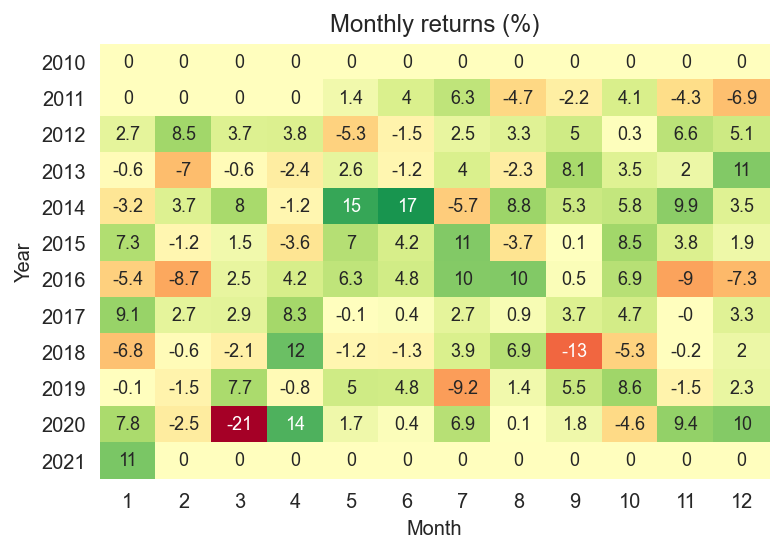

In [25]:
pf.plot_monthly_returns_heatmap(returns)

In [26]:
import dtale

In [27]:
returns.index = returns.index.to_pydatetime() 

In [28]:
dtale.show(returns, ignore_duplicate=True)